# Data Scientist Nanodegree
## Convolutional Neural Networks

### Project: Write an Algorithm for a Dog Identification App 

---

This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed. 

---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, the app will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project. 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [16]:
import numpy as np
import pandas as pd
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


## Data Visualisation

In this part, I'll build data visualisations to further convey the information associated with our dataset. 

I will explore the dogs dataset to check:
- how the number of images are distributed among dog breeds;
- how many unique dog breeds there are;
- if there is a semnificative difference between the number of images for each breed.

In [21]:
# convert the dog_files array into a pandas DataFrame for easy manipulation
df_dogs = pd.DataFrame(dog_files, columns=['filename'])
df_dogs.head()

,filename
0,/data/dog_images/train/103.Mastiff/Mastiff_068...
1,/data/dog_images/train/103.Mastiff/Mastiff_068...
2,/data/dog_images/train/103.Mastiff/Mastiff_068...
3,/data/dog_images/train/103.Mastiff/Mastiff_068...
4,/data/dog_images/train/103.Mastiff/Mastiff_068...


We can see that our filename structure contains the dog breed. Therefore, I will split the filename and get the dog breed information from it.

In [26]:
# split the filename to get needed information
df_dog_info = df_dogs['filename'].str.split('/', expand=True)[[3, 4, 5]]
# rename columns
df_dog_info.columns = ['dataset', 'dog_breed', 'filename']
# let's check our newly created dataframe
df_dog_info.head()

,dataset,dog_breed,filename
0,train,103.Mastiff,Mastiff_06833.jpg
1,train,103.Mastiff,Mastiff_06826.jpg
2,train,103.Mastiff,Mastiff_06871.jpg
3,train,103.Mastiff,Mastiff_06812.jpg
4,train,103.Mastiff,Mastiff_06831.jpg


Now we have our dog breed and this also needs a split. We can see that it contains a number continued by a dot.

In [33]:
# split the dog breed column and get the actual name of the dog's breed
df_dog_info['dog_breed'] = df_dog_info['dog_breed'].str.split('.').str[1]
# let's check our result
df_dog_info.head()

,dataset,dog_breed,filename
0,train,Mastiff,Mastiff_06833.jpg
1,train,Mastiff,Mastiff_06826.jpg
2,train,Mastiff,Mastiff_06871.jpg
3,train,Mastiff,Mastiff_06812.jpg
4,train,Mastiff,Mastiff_06831.jpg


In [37]:
# number of unique dob breeds
df_dog_info['dog_breed'].nunique()

133

We can see that we have 133 unique dog breeds in our file distribution. Let's check how many images are in each file

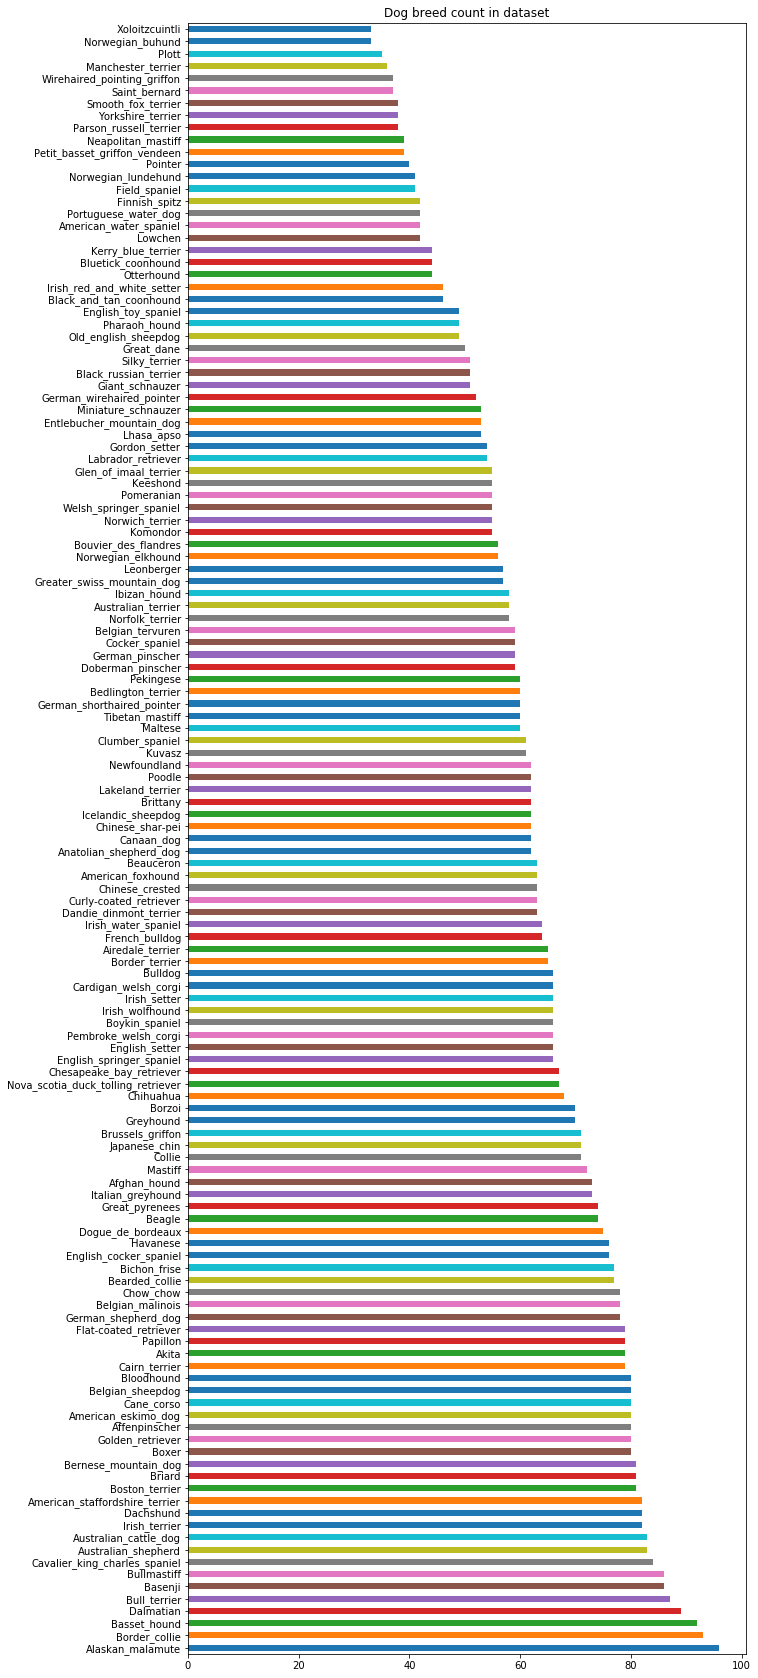

In [59]:
df_dog_info['dog_breed'].value_counts().plot(kind='barh', figsize=(10,30));
plt.title('Dog breed count in dataset');

Our distribution of dog images goes from 96 for the Alaskan Malamute to a minimum of 33 for the Norwegian buhund and Xoloitzcuintli.

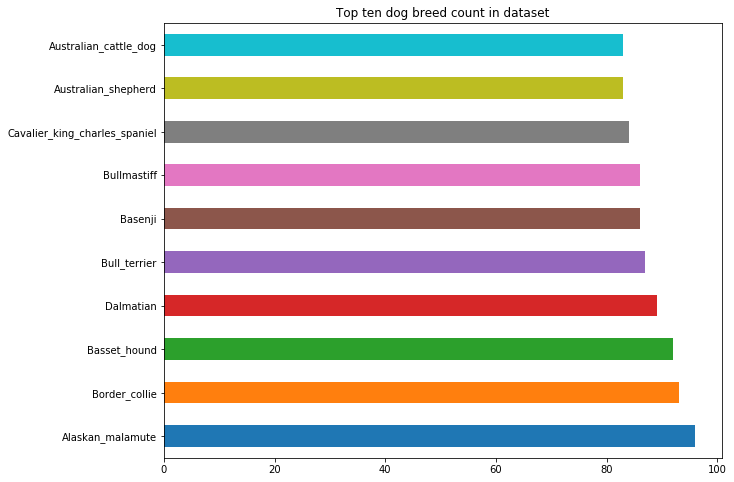

In [60]:
df_dog_info['dog_breed'].value_counts()[:10].plot(kind='barh', figsize=(10,8))
plt.title('Top ten dog breed count in dataset');

These are top ten the dog breeds in our dataset, at around 90 images.

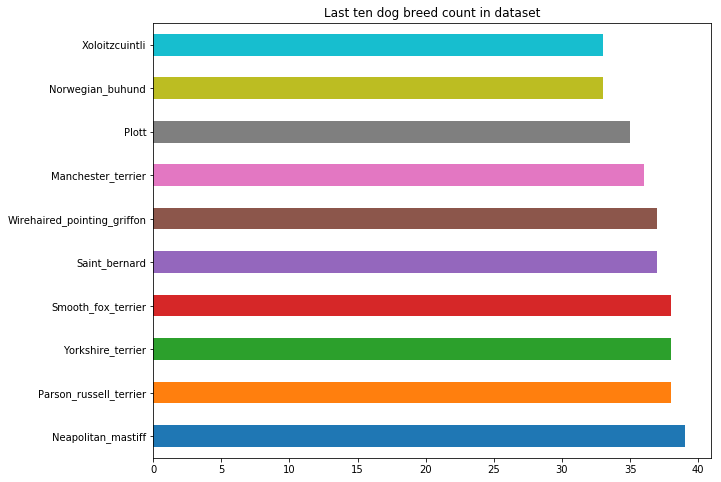

In [61]:
df_dog_info['dog_breed'].value_counts()[-10:].plot(kind='barh', figsize=(10,8))
plt.title('Last ten dog breed count in dataset');

These are the last ten dog breeds in our dataset, at around 30-40 images.

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](https://docs.opencv.org/master/d2/d99/tutorial_js_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


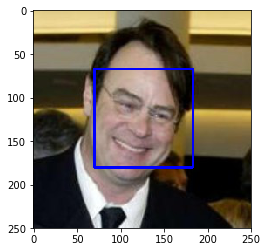

In [5]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
def face_detector(img_path):
    """
        INPUT
            img_path - a string-valued file path to an image
        OUTPUT
            returns "True" if face is detected in image stored at img_path
    """
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
* In the first 100 images in `human_files`, 98% have a detected human face.
* In the first 100 images in `dog_files`, 17% have a detected human face.

In [7]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

count_humans = 0
count_dogs = 0

for i in tqdm(range(100)):
    count_humans += int(face_detector(human_files_short[i]))
    count_dogs += int(face_detector(dog_files_short[i]))

100%|██████████| 100/100 [00:40<00:00,  3.47it/s]


In [8]:
percentage_humans = count_humans / 100 * 100
percentage_dogs = count_dogs / 100 * 100

# percentages of the first 100 images with a human face detected
percentage_humans, percentage_dogs

(98.0, 17.0)

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](https://pytorch.org/vision/stable/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [9]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:08<00:00, 61804508.97it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

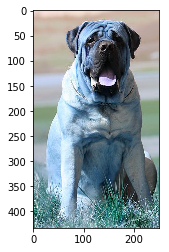

In [10]:
# load color (BGR) image
img = cv2.imread(dog_files[2])

# display the image, along with bounding box
plt.imshow(img)
plt.show()

### Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](https://pytorch.org/vision/stable/models.html).

In [8]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path.
    
    INPUT:
        img_path - a string-valued file path to an image
    OUTPUT:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # load the image
    image = Image.open(img_path)
    # transform the image
    in_transform = transforms.Compose([
                                    transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    VGG16.eval()
    
    if use_cuda:
        image = image.cuda()
        
    output = VGG16(image)
    
    # predicted class
    return output.data.argmax(dim=1) #np.argmax(VGG16.forward(image).detach().numpy()) # predicted class index

In [9]:
VGG16_predict(dog_files[2])

tensor([ 243], device='cuda:0')

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
def dog_detector(img_path):
    """
        INPUT
            img_path - a string-valued file path to an image
        OUTPUT
            returns "True" if a dog is detected in the image stored at img_path
    """
    
    predicted_class = VGG16_predict(img_path)
    
    if  (predicted_class >= 151) and (predicted_class <= 268):
        return True 
    else:
        return False

In [11]:
dog_detector(dog_files[6000])

True

### Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
* In the first 100 images in `human_files`, 0% have detected a dog.
* In the first 100 images in `dog_files`, 100% have detected a dog.

In [12]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
count_humans = 0
count_dogs = 0

for i in tqdm(range(100)):
    count_humans += int(dog_detector(human_files_short[i]))
    count_dogs += int(dog_detector(dog_files_short[i]))

100%|██████████| 100/100 [00:07<00:00, 15.20it/s]


In [13]:
percentage_humans = count_humans / 100 * 100
percentage_dogs = count_dogs / 100 * 100

# percentages of the first 100 images with a dog detected
percentage_humans, percentage_dogs

(0.0, 100.0)

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | 
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">

Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](https://pytorch.org/vision/stable/transforms.html)!

In [14]:
import os
from torchvision import datasets

### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
data_dir = '/data/dog_images/'

# Define transforms for the training data and testing data
data_transforms = {'train' : transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]),
                    'test' : transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])]),
                    'valid' : transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                          for x in ['train', 'test', 'valid']}

# how many samples per batch to load
batch_size = 20
# number of subprocesses to use for data loading
num_workers = 0

# data loaders 
dataloaders = {"train" : torch.utils.data.DataLoader(image_datasets['train'],
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True),
               "valid" : torch.utils.data.DataLoader(image_datasets['valid'],
                                                           batch_size=batch_size, 
                                                           num_workers=num_workers,
                                                           shuffle=False),
               "test" : torch.utils.data.DataLoader(image_datasets['test'],
                                                           batch_size=batch_size, 
                                                           num_workers=num_workers,
                                                           shuffle=False)}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'valid']}
class_names = image_datasets['train'].classes

In [15]:
# number of classes
num_classes = len(image_datasets['train'].classes)
num_classes

133

In [16]:
# number of images in train, test and valid
dataset_sizes

{'train': 6680, 'test': 836, 'valid': 835}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:

* Because the images have different sizes, they are resized to be `224*224`. This way, they will be consistent for our model which needs the same input size every time.   
* For the training data, I performed simple data augmentation by randomly flipping and randomly rotating by a range of  +/-30 degrees. This allows for rotation invariance because the angle of the dogs doesn't matter. Therefore, I add images to the training set with random rotations. These methods will help us reduce overfitting.
* For the validation and testing data, images are only resized and center cropped for a `224*224` size. 
* Our images are transformed into a tensor so they can be a valid input for the model.
* After that, I normalize the tensors with a mean and standard deviation.

### Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    """
    A class to define the CNN architecture of our model.
    """
    def __init__(self):
        super(Net, self).__init__()
        """
            In the constructor we define three convolutional layers, a max pooling layer, 
            two fully connected layers and a dropout layer with an input probability of 0.3.
        """
        ## Define layers of a CNN
        # 224*224*3
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        # 56*56*32
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        # 14*14*64
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        # 7*7*128

        # pool
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully-connected
        self.fc1 = nn.Linear(7*7*128, 500)
        self.fc2 = nn.Linear(500, num_classes) 
        
        # drop-out
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        """
            A function that defines forward behavior. In the forward function we accept a Tensor of input data 
            and we must return a Tensor of output data. We use Modules defined in the constructor as.
            INPUT
                x - a Tensor of input data
            OUTPUT
                x - a Tensor of output data
        """
        
        # Pass data through conv1
        # Use the rectified-linear activation function over x
        x = F.relu(self.conv1(x))
        # Run max pooling over x
        x = self.pool(x)
        # Pass data through conv2
        # Use the rectified-linear activation function over x
        x = F.relu(self.conv2(x))
        # Run max pooling over x
        x = self.pool(x)
        # Pass data through conv3
        # Use the rectified-linear activation function over x
        x = F.relu(self.conv3(x))
        # Run max pooling over x
        x = self.pool(x)
        
        # flatten the tensor
        x = x.view(-1, 7*7*128)
        
        # Pass data through dropout
        x = self.dropout(x)
        # Pass data through fc1 and apply relu
        x = F.relu(self.fc1(x))
        
        # Pass data through dropout
        x = self.dropout(x)
        # Pass data through fc2 and apply relu
        x = self.fc2(x)
        return x


# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.3)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

First, I tried different CNN model architectures to classify dog breeds. I found out that this particular one, which downsizes my input’s x-y dimensions by a factor of 2 to the power of 5 and increases its depth from 3 to 128, is suitable for my task of obtaining an accuracy of at least 10%.

The model’s architecture contains 3 convolutional layers which gradually increases the depth of the input from 3 to 32 to 64 and finally to 128.  They all have a convolution kernel size of `3*3`. These image filters extract features like edges of objects which allows us to make better predictions. Also, in order to pass the `3*3` kernel to all 224 pixels of our input, we need to add a padding of 1 that pads it with a border of 0, black pixels. The stride of the convolution, or the amount by which the filter slides over the image is 2. It makes the convolutional layer about half the width and height as the input image.  

A ReLu activation function is applied to the output of these filters to standardize their output values. After the convolutional layer, to reduce the dimensionality of our input arrays by a factor of two, I will apply `2*2` Max Pooling layers. In a `2*2` window it returns the maximum of the pixels contained in the window. It sees 4 pixels and returns one, decreasing the x-y dimensions by a factor of 2.

As it moves through the model, the input array transforms its dimensions:

* From `224*224*3`
* After first convolutional layer: `112*112*32`
* After first Max pooling layer:  `56*56*32`
* After second convolutional layer: `28*28*64`
* After second Max pooling layer:  `14*14*64`
* After third convolutional layer (has a stride of 1): `14*14*128`
* After thirdMax pooling layer:  `7*7*128`

Then, the input array is flattened and passed through two fully connected layers which will give us the predictions. I have specified a dropout probability of 0.3 and a relu activation function.

### Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](https://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [18]:
import torch.optim as optim

# specify loss function
criterion_scratch = nn.CrossEntropyLoss()

# specify optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.05)

### Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](https://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [19]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, last_validation_loss=None):
    """
        INPUT
            n_epochs - number of iterations to train the model
            loaders - data loaders for the training, validation, and test datasets of dog images, 
                      an iterable over a dataset
            model - an instantiated Net() model 
            optimizer - an optimizer object that implements an optimization algorithm
            criterion - a loss function
            use_cuda - move model to GPU if CUDA is available
            save_path - a string-valued file path to save a model
            last_validation_loss - tracker for minimum validation loss
        OUTPUT
            model - trained model
    """
    # initialize tracker for minimum validation loss
    if last_validation_loss is not None:
        valid_loss_min = last_validation_loss
    else:
        valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move tensors to GPU if CUDA is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step: parameter update
            optimizer.step()
            # update average train loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average valid loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [20]:
# train the model
model_scratch = train(50, dataloaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.875506 	Validation Loss: 4.832005
Validation loss decreased (inf --> 4.832005).  Saving model ...
Epoch: 2 	Training Loss: 4.759482 	Validation Loss: 4.573721
Validation loss decreased (4.832005 --> 4.573721).  Saving model ...
Epoch: 3 	Training Loss: 4.633123 	Validation Loss: 4.587683
Epoch: 4 	Training Loss: 4.574293 	Validation Loss: 4.404909
Validation loss decreased (4.573721 --> 4.404909).  Saving model ...
Epoch: 5 	Training Loss: 4.518422 	Validation Loss: 4.329000
Validation loss decreased (4.404909 --> 4.329000).  Saving model ...
Epoch: 6 	Training Loss: 4.481297 	Validation Loss: 4.267406
Validation loss decreased (4.329000 --> 4.267406).  Saving model ...
Epoch: 7 	Training Loss: 4.425004 	Validation Loss: 4.333524
Epoch: 8 	Training Loss: 4.370855 	Validation Loss: 4.269346
Epoch: 9 	Training Loss: 4.313859 	Validation Loss: 4.151904
Validation loss decreased (4.267406 --> 4.151904).  Saving model ...
Epoch: 10 	Training Loss: 4.261094 	Valida

### Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [21]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

def test(loaders, model, criterion, use_cuda):
    """
        INPUT
            loaders - data loaders for the training, validation, and test datasets of dog images, 
                      an iterable over a dataset
            model - a trained model
            criterion - a loss function
            use_cuda - move model to GPU if CUDA is available
    """

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(dataloaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.145087


Test Accuracy: 25% (216/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](https://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

In [22]:
# write three separate data loaders 
loaders_transfer = {
    "train" : torch.utils.data.DataLoader(image_datasets['train'],
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True),
    "valid" : torch.utils.data.DataLoader(image_datasets['valid'],
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False),
    "test" : torch.utils.data.DataLoader(image_datasets['test'],
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)}

### Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [30]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.densenet121(pretrained=True)

# freeze parameters so we won't backprop through them
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
## Specify model architecture 

# get the in_features from classifier
n_inputs = model_transfer.classifier.in_features
# # add last layer
model_transfer.classifier = nn.Linear(n_inputs, num_classes)

# # if GPU is available, move the model to GPU
if use_cuda:
    model_transfer = model_transfer.cuda()

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

* Trained a convolutional neural network for image classification with learning transfer. 
* Initialized densenet121 pretrained model and freezed its parameters.
* Reshaped the final layer to have the same number of outputs as the number of classes from our dataset.
* Defined Adam for the optimization algorithm that will update the classifier's parameters.
* Defined the loss function and trained the model for two epochs which gave an accuracy of 80% on the testing set,.

### Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](https://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](https://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [31]:
# specify loss function
criterion_transfer = nn.CrossEntropyLoss()
# specify optimizer and learning rate of 0.001
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.001)

### Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](https://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [32]:
# train the model
model_transfer = train(3, loaders_transfer, model_transfer, 
                       optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 3.059226 	Validation Loss: 1.260849
Validation loss decreased (inf --> 1.260849).  Saving model ...
Epoch: 2 	Training Loss: 1.566109 	Validation Loss: 0.812038
Validation loss decreased (1.260849 --> 0.812038).  Saving model ...
Epoch: 3 	Training Loss: 1.248436 	Validation Loss: 0.633346
Validation loss decreased (0.812038 --> 0.633346).  Saving model ...


### Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [33]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.677304


Test Accuracy: 80% (673/836)


### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [34]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    """
    A function that takes a path to an image as input and returns the dog breed that is predicted by the model.
    INPUT
        img_path - a string-valued file path to an image
    OUTPUT
        dog_breed - the dog breed that is predicted by the model
    """
    # load the image and return the predicted breed
    
    # load the image
    image = Image.open(img_path)
    
    # transform the image
    in_transform = transforms.Compose([
                                    transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])])

    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    # set the model on evaluation mode
    model_transfer.eval()

    if use_cuda:
        image = image.cuda()
        
    # get the predictions
    output = model_transfer(image)
    
    # predicted dog breed
    dog_breed = class_names[output.data.argmax(dim=1)]
    
    return dog_breed

In [35]:
predict_breed_transfer(dog_files[5000])

'Bulldog'

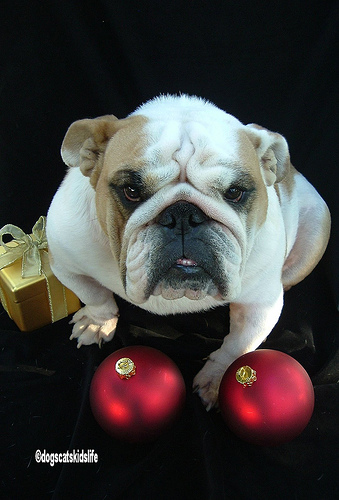

In [36]:
Image.open(dog_files[5000])

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.

### Write your Algorithm

In [37]:
def run_app(img_path):
    """
    INPUT
        img_path - a string-valued file path to an image
    """
    ## handle cases for a human face, dog, and neither
    image = Image.open(img_path)
    plt.imshow(image)
    plt.show()
    
    if dog_detector(img_path):
        print(predict_breed_transfer(img_path))
    elif face_detector(img_path):
        print(f"You look like a {predict_breed_transfer(img_path)}")
    else:
        print('Error')

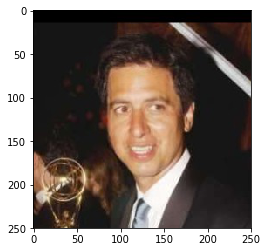

You look like a English springer spaniel


In [38]:
run_app(human_files[4000])

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The model does a pretty good job at classifying dog breeds and gives a human a funny dog breed estimator but there are ways to improve our algorithm.

* We can finetune the transfer model to obtain higher accuracy on the dog breed classifier. 
* We can add more real-world images in our dataset for the model to train and improve performance.
* We can add more data augmentation transforms so that the model sees variation of the input images.

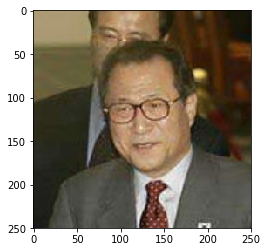

You look like a English springer spaniel


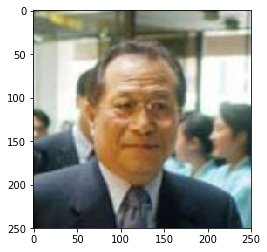

You look like a Dogue de bordeaux


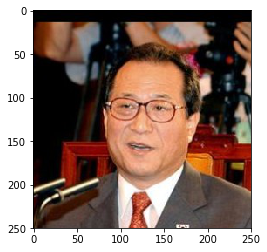

You look like a Collie


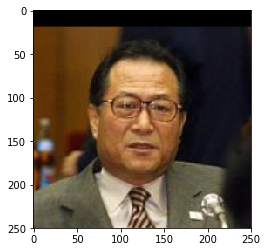

You look like a English springer spaniel


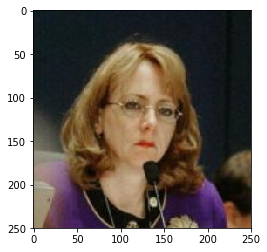

You look like a Dachshund


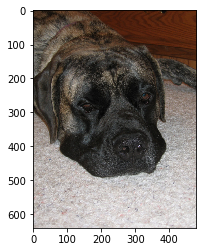

Mastiff


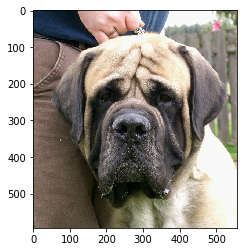

Mastiff


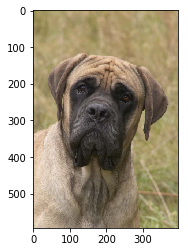

Mastiff


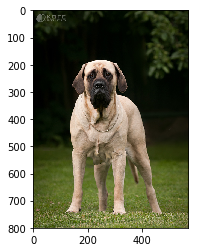

Mastiff


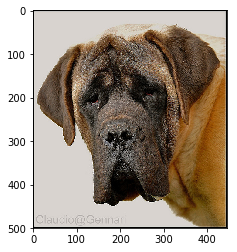

Mastiff


In [42]:
for file in np.hstack((human_files[10:15], dog_files[10:15])):
    run_app(file)